# Generative Adversarial Networks

In [1]:
%matplotlib inline
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from keras.utils.generic_utils import Progbar
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from PIL import Image

Using TensorFlow backend.


## Bulid Generator

In [2]:
G_Input          = Input(shape=(100,))
G_Dense_1        = Dense(1024, activation=LeakyReLU())(G_Input)
G_Dense_2        = Dense(7*7*128, activation=LeakyReLU())(G_Dense_1)
G_Reshape        = Reshape((7,7,128))(G_Dense_2)
G_ConvTrans_1    = Conv2DTranspose(128, (5, 5), strides=2, activation=LeakyReLU(), padding='same')(G_Reshape)
G_ConvTrans_1_BN = BatchNormalization()(G_ConvTrans_1)
G_ConvTrans_2    = Conv2DTranspose(64, (5, 5), activation=LeakyReLU(), padding='same')(G_ConvTrans_1_BN)
G_ConvTrans_2_BN = BatchNormalization()(G_ConvTrans_2)
G_ConvTrans_3    = Conv2DTranspose(64, (5, 5), strides=2, activation=LeakyReLU(), padding='same')(G_ConvTrans_2_BN)
G_ConvTrans_3_BN = BatchNormalization()(G_ConvTrans_3)
G_ConvTrans_4    = Conv2DTranspose(1, (5, 5), activation='tanh', padding='same')(G_ConvTrans_3_BN)

generator = Model(G_Input, G_ConvTrans_4, name='Generator')
generator.compile(loss='binary_crossentropy', optimizer='SGD')
print('Generator')
generator.summary()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    


## Bulid Discriminator

In [3]:
D_input   = Input(shape=((28,28,1)))
D_Conv_1  = Convolution2D(64, (5, 5), padding='same', activation=LeakyReLU())(D_input)
D_Conv_2  = Convolution2D(128, (5, 5), strides=2, activation=LeakyReLU())(D_Conv_1)
D_Conv_3  = Convolution2D(128, (5, 5), strides=2, padding='same',activation=LeakyReLU())(D_Conv_2)
D_Flatten = Flatten()(D_Conv_3)
D_Dense_1 = Dense(1024, activation=LeakyReLU())(D_Flatten)
D_Dense_2 = Dense(1)(D_Dense_1)

discriminator = Model(D_input, D_Dense_2, name='Discriminator')
discriminator.compile(loss='binary_crossentropy', optimizer='SGD')
print('Discriminator')
discriminator.summary()

Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         409728    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025   

# Define middle layer

In [4]:
GAN_input = Input(shape=(100,))

In [5]:
fake_img = generator(GAN_input)

In [6]:
real_or_fake = discriminator(fake_img)

## Make the model for training generator

In [7]:
print(discriminator.trainable)

True


In [8]:
for layer in discriminator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True


### make discriminator untrainable

In [9]:
discriminator.trainable = False

In [10]:
print(discriminator.trainable)

False


In [11]:
for layer in discriminator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True


In [12]:
for layer in discriminator.layers:
    layer.trainable = False

In [13]:
for layer in discriminator.layers:
    print(layer.trainable)

False
False
False
False
False
False
False


### Compile model for training generator

In [14]:
model_for_training_generator = Model(GAN_input, real_or_fake)

model_for_training_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 28, 28, 1)         7251905   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 5336961   
Total params: 12,588,866
Trainable params: 7,251,393
Non-trainable params: 5,337,473
_________________________________________________________________


In [15]:
model_for_training_generator.compile(optimizer='SGD', loss='binary_crossentropy')

## Make discriminator be trainable again

In [16]:
for layer in discriminator.layers:
    layer.trainable = True
discriminator.trainable = True

In [17]:
discriminator.trainable

True

In [18]:
for layer in discriminator.layers:
    print(layer.trainable)

True
True
True
True
True
True
True


## Loading MNIST

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train = X_train / 255
X_train.shape

(60000, 28, 28, 1)

In [20]:
batch_size = 16

## Make answers

In [21]:
answer_for_generator = np.ones(batch_size)
answer_for_generator = answer_for_generator.reshape(16,1)
answer_for_generator.shape

(16, 1)

In [22]:
answer_for_discriminator = np.array([1] * batch_size + [0] * batch_size)
answer_for_discriminator = answer_for_discriminator.reshape(32,1)
answer_for_discriminator.shape

(32, 1)

# Make a epoch

In [23]:
number_of_batch = int(X_train.shape[0]/batch_size)

In [24]:
number_of_batch

3750

### Shuffle the training data

In [25]:
np.random.shuffle(X_train)

### Train by batch

In [26]:
epoch_g_loss = []
epoch_d_loss = []
for index in range(number_of_batch):
    noise = np.random.rand(batch_size, 100)
    real_batch = X_train[index * batch_size:(index + 1) * batch_size]
    fake_batch = generator.predict(noise)
    img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
    #Train Discriminator First
    epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
    print(epoch_d_loss[index])
    noise = np.random.rand(batch_size, 100)
    epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
    print(epoch_g_loss[index])

6.15578
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07
7.97119
1.19209e-07


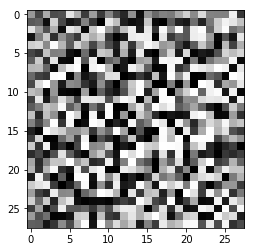

In [27]:
test_noise = np.random.rand(1, 100)
generator_image = generator.predict(test_noise)
generator_image = generator_image.reshape(28,28)
plt.imshow(generator_image,cmap='gray')

In [28]:
epoch_g_loss = []
epoch_d_loss = []
progress_bar = Progbar(target=number_of_batch)
for index in range(number_of_batch):
    progress_bar.update(index)
    noise = np.random.rand(batch_size, 100)
    real_batch = X_train[index * batch_size:(index + 1) * batch_size]
    fake_batch = generator.predict(noise)
    img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
    #Train Discriminator First
    epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
    #print(epoch_d_loss[index])
    noise = np.random.rand(batch_size, 100)
    epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
    #print(epoch_g_loss[index])

3749/3750 [============================>.] - ETA: 0s  

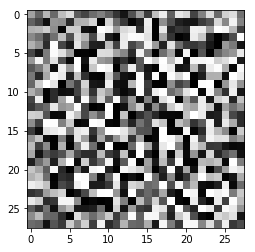

In [29]:
test_noise = np.random.rand(1, 100)
generator_image = generator.predict(test_noise)
generator_image = generator_image.reshape(28,28)
plt.imshow(generator_image,cmap='gray')

In [33]:
epochs = 500

In [ ]:
for epoch in range(epochs):
    print(epoch)
    epoch_g_loss = []
    epoch_d_loss = []
    #progress_bar = Progbar(target=number_of_batch)
    for index in range(number_of_batch):
        #progress_bar.update(index)
        noise = np.random.rand(batch_size, 100)
        real_batch = X_train[index * batch_size:(index + 1) * batch_size]
        fake_batch = generator.predict(noise)
        img_batch  = np.concatenate((real_batch,fake_batch), axis=0)
        #Train Discriminator First
        epoch_d_loss.append(discriminator.train_on_batch(img_batch,answer_for_discriminator))
        #print(epoch_d_loss[index])
        noise = np.random.rand(batch_size, 100)
        epoch_g_loss.append(model_for_training_generator.train_on_batch(noise, answer_for_generator))
        #print(epoch_g_loss[index])
    generator_image = generator.predict(test_noise)
    generator_image = generator_image.reshape(28,28)
    plt.imshow(generator_image,cmap='gray')

0
1
2
3
4
5
